Fake News

data description

id: unique id for a news article
title: the title of a news article
author: author of the news article
text: the text of the article; could be incomplete
label: a label that marks the article as potentially unreliable
1: unreliable
0: reliable

Import Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news/train.csv
/kaggle/input/fake-news/submit.csv
/kaggle/input/fake-news/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import seaborn as sns
import re

In [3]:
df =pd.read_csv('/kaggle/input/fake-news/train.csv' ,  encoding='ISO-8859-1')

df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didnât Even See Comeyâs...,Darrell Lucus,House Dem Aide: We Didnât Even See Comeyâs...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
df.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

## Lets remove where we dont have text

In [5]:
df_news = df[~df['text'].isna()][['text','label']]

In [6]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20761 entries, 0 to 20799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20761 non-null  object
 1   label   20761 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 486.6+ KB


## Lets remove duplicates

In [7]:
df_news.drop_duplicates(subset=['text'],keep='first',inplace=True)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20386 entries, 0 to 20799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20386 non-null  object
 1   label   20386 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 477.8+ KB


## Number of words

Let's compare the number of words in the fake news and real news and try to distinguish pattern in the fake and real news based on number of words used

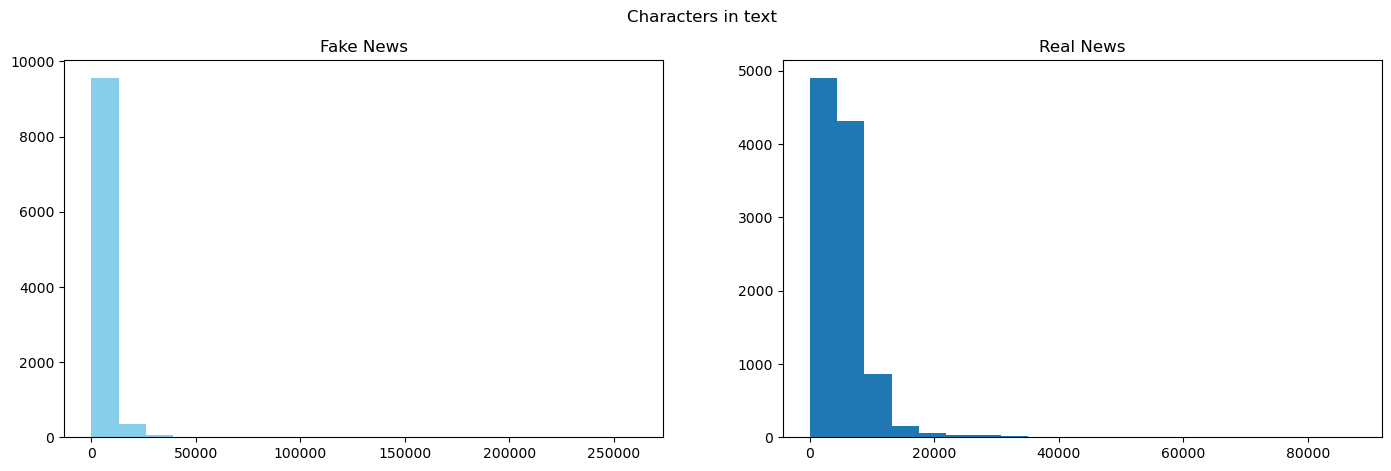

In [8]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
length=df_news[df_news["label"]==1]['text'].str.len()
ax1.hist(length,bins = 20,color='skyblue')
ax1.set_title('Fake News')
length=df_news[df_news["label"]==0]['text'].str.len()
ax2.hist(length, bins = 20)
ax2.set_title('Real News')
fig.suptitle('Characters in text')
plt.show()

## General Word Cloud 

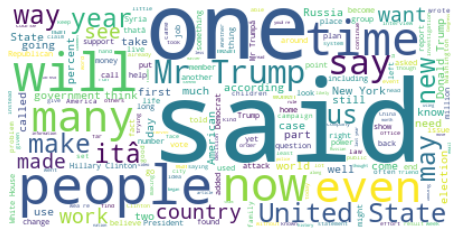

In [9]:
text = " ".join([x for x in df_news.text])

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

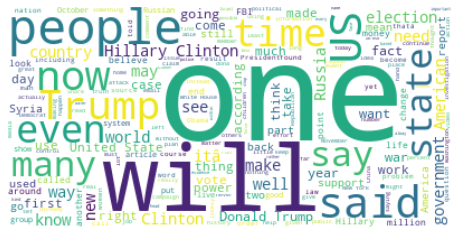

In [10]:
## for fake

text = " ".join([x for x in df_news.text[df_news.label==1]])

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

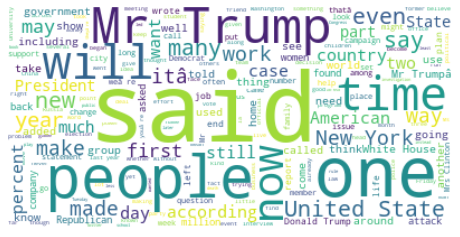

In [11]:
## for real

text = " ".join([x for x in df_news.text[df_news.label==0]])

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [12]:
print('Number of 0 (Not Fake) : ', df_news["label"].value_counts()[0])
print('Number of 1 (Fake) : ', df_news["label"].value_counts()[1])

Number of 0 (Not Fake) :  10387
Number of 1 (Fake) :  9999


Text(0.5, 1.0, 'Target Count')

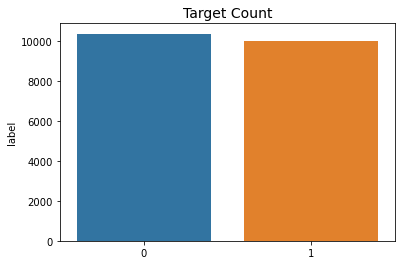

In [13]:
label = df_news["label"].value_counts()
sns.barplot(label.index, label)
plt.title('Target Count', fontsize=14)

## Text Cleaning

In [14]:
# Dataset Preprocessing
def text_cleaning(text):
    text = re.sub("[^a-zA-Z]", " ", text) # removing punctuation
    return text

df_news['text'] = df_news['text'].apply(text_cleaning)

## Train Test Split

In [15]:
train_df,eval_df = train_test_split(df_news,test_size = 0.05)

## install simpletransformers

In [16]:
!pip install simpletransformers==0.32.3

     |████████████████████████████████| 187 kB 595 kB/s 
  Created wheel for seqeval: filename=seqeval-0.0.12-py3-none-any.whl size=7423 sha256=60bdb8001a30b4f6fdece1ced40de43bbeb06b9e6937de99ed6e8dac79db92a4
  Stored in directory: /root/.cache/pip/wheels/dc/cc/62/a3b81f92d35a80e39eb9b2a9d8b31abac54c02b21b2d466edc
Successfully built seqeval


In [17]:
from simpletransformers.classification import ClassificationModel


# Create a TransformerModel
model = ClassificationModel('bert', 'bert-base-cased', num_labels=2, 
                            args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=False)


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [18]:
model.train_model(train_df)

/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:263: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.438705

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.693655

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.003956



In [19]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:683: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


In [20]:
print(result)
print(model_outputs)

{'mcc': 0.9467881493512242, 'tp': 460, 'tn': 533, 'fp': 14, 'fn': 13, 'eval_loss': 0.10298729727242062}
[[ 3.3233294 -2.9357438]
 [ 3.790258  -3.3570027]
 [-4.5026636  3.7114224]
 ...
 [ 2.0710807 -1.6211444]
 [-4.220293   3.5086   ]
 [ 2.7560098 -2.352809 ]]


In [21]:
lst = []
for arr in model_outputs:
    lst.append(np.argmax(arr))

In [22]:
true = eval_df['label'].tolist()
predicted = lst

In [23]:
import sklearn
mat = sklearn.metrics.confusion_matrix(true , predicted)
mat

array([[533,  14],
       [ 13, 460]])

In [24]:
print(sklearn.metrics.classification_report(true,predicted,target_names=['real','fake']))


              precision    recall  f1-score   support

        real       0.98      0.97      0.98       547
        fake       0.97      0.97      0.97       473

    accuracy                           0.97      1020
   macro avg       0.97      0.97      0.97      1020
weighted avg       0.97      0.97      0.97      1020



In [25]:
test_df =pd.read_csv('/kaggle/input/fake-news/test.csv' ,  encoding='ISO-8859-1')

test_df.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. â After years of scorni..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you donât succeed, try a differe..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [26]:
test_df.isna().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [27]:
test_df.fillna('' , inplace=True)

In [28]:
test_df['text'] = test_df['text'].apply(text_cleaning)

In [29]:
final_prediction = model.predict(list(test_df.text))

In [30]:
final_prediction

(array([0, 1, 1, ..., 0, 1, 0]),
 array([[ 4.036139 , -3.7276862],
        [-4.334202 ,  3.575842 ],
        [-4.3871355,  3.6260188],
        ...,
        [ 4.0245667, -3.5926793],
        [-4.516941 ,  3.6961944],
        [ 3.3479438, -2.9567742]], dtype=float32))